In [1]:
#STEP 1 
#IMPORTING IMPORTANT LIBRARIRES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report , confusion_matrix, recall_score,precision_score
from imblearn.over_sampling import SMOTE #Fixes imbalanced data by creating realistic minority samples
import warnings #Hides non-critical warning messages
warnings.filterwarnings('ignore')

#set random seed for reproducibiltity
np.random.seed(42) #ensures that “random” things behave the same way every time you run the code.


In [2]:
#STEP 2:
#LETS LOAD THE DATA

df = pd.read_csv("Insurance claims data.csv")

print("Dataset Shape:",df.shape)
print("\nFirst 5 rows :")
print(df.head())
print("\nDatatypes:")
print(df.dtypes)
print("nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (58592, 41)

First 5 rows :
   policy_id  subscription_length  vehicle_age  customer_age region_code  \
0  POL045360                  9.3          1.2            41          C8   
1  POL016745                  8.2          1.8            35          C2   
2  POL007194                  9.5          0.2            44          C8   
3  POL018146                  5.2          0.4            44         C10   
4  POL049011                 10.1          1.0            56         C13   

   region_density segment model fuel_type     max_torque  ... is_brake_assist  \
0            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
1           27003      C1    M9    Diesel  200Nm@1750rpm  ...              No   
2            8794      C2    M4    Diesel  250Nm@2750rpm  ...             Yes   
3           73430       A    M1       CNG   60Nm@3500rpm  ...              No   
4            5410      B2    M5    Diesel  200Nm@3000rpm  ...              No   

  is_power_do

 Target Variable distribution:
claim_status
0    54844
1     3748
Name: count, dtype: int64

Percentage Distribution:
claim_status
0    93.603222
1     6.396778
Name: proportion, dtype: float64


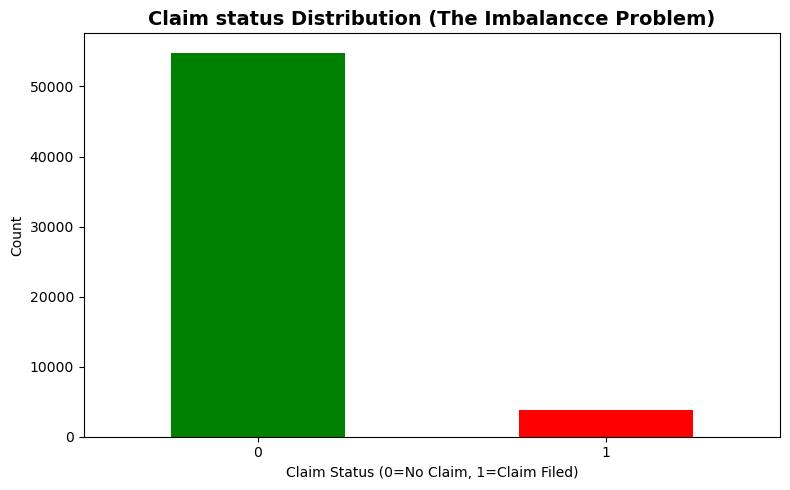


 Imbalance Ratio: 14.6:1
 For every 1 claim , there are 14.6 non-claims!


In [3]:
#STEP 3
#CHECKING FOR IMBLANCE

#checking target distribution
print(" Target Variable distribution:")
print(df['claim_status'].value_counts())
print("\nPercentage Distribution:")
print(df['claim_status'].value_counts(normalize=True)*100)

#visualising the imbalance
plt.figure(figsize=(8,5))
df['claim_status'].value_counts().plot(kind='bar', color=['green','red'])
plt.title('Claim status Distribution (The Imbalancce Problem)',fontsize=14,fontweight='bold')
plt.xlabel('Claim Status (0=No Claim, 1=Claim Filed)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout() #Automatically adjust spacing so everything fits nicely
plt.show()

#lets calculate the imbalance ratio
majority_class =df['claim_status'].value_counts()[0] #first (most frequent) value → majority
minority_class =df['claim_status'].value_counts()[1] #second (less frequent) value → minority
imbalance_ratio = majority_class/minority_class
print(f"\n Imbalance Ratio: {imbalance_ratio:.1f}:1")
print(f" For every 1 claim , there are {imbalance_ratio:.1f} non-claims!")

In [4]:
#STEP4:DATA CLEANING AND PREPARATION
#make a copy for processing
data =df.copy()

#handling missing values if any (we have none but just been precautious)
print("Cleaning data...")

#for numerical columns ,fill with median
numerical_cols =data.select_dtypes(include=['float64','int64']).columns
for col in numerical_cols:
    if data[col].isnull().sum()>0:
        data[col].fillna(data[col].median(),inplace=True)
        
#for categorical columns ,fill with mode
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols :
    if col !='claim_status' and data[col].isnull().sum()>0:
        data[col].fillna(data[col].mode()[0],inplace=True)
        
print("Missing Values Handled!")

print("\nData Info After Cleaning")
print(data.info())

Cleaning data...
Missing Values Handled!

Data Info After Cleaning
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  object 
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  object 
 7   model                             58592 non-null  object 
 8   fuel_type                         58592 non-null  object 
 9   max_torque                        58592 non-null  object 
 10  max_power                         58592 non-null  object 
 11  

In [5]:
#STEP 5:FEATURE ENGINERING

#separate features adn target
X = data.drop('claim_status',axis =1)
y = data['claim_status']

#droping the id column not useful
if 'policy_id' in X.columns:
    X = X.drop('policy_id',axis=1)
    
#Encode categorical variables
print("Engineering features...")

#create label encoders for categorical columns
label_encoders={}
categorical_features = X.select_dtypes(include=['object']).columns

for col in categorical_features:
    le =LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"Encoded {col}")
    
print("\nAll Features are now numerical!")
print(f"\nFinal features count: {X.shape[1]}")
print(f"Targetnsamples:{len(y)}")

Engineering features...
Encoded region_code
Encoded segment
Encoded model
Encoded fuel_type
Encoded max_torque
Encoded max_power
Encoded engine_type
Encoded is_esc
Encoded is_adjustable_steering
Encoded is_tpms
Encoded is_parking_sensors
Encoded is_parking_camera
Encoded rear_brakes_type
Encoded transmission_type
Encoded steering_type
Encoded is_front_fog_lights
Encoded is_rear_window_wiper
Encoded is_rear_window_washer
Encoded is_rear_window_defogger
Encoded is_brake_assist
Encoded is_power_door_locks
Encoded is_central_locking
Encoded is_power_steering
Encoded is_driver_seat_height_adjustable
Encoded is_day_night_rear_view_mirror
Encoded is_ecw
Encoded is_speed_alert

All Features are now numerical!

Final features count: 39
Targetnsamples:58592


In [6]:
#STEP 6:
#SPLIT data into training and testing sets

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#Keep class balance same after splitting
print("Data split complete!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

print("\nTraining set distribution:")
print(y_train.value_counts(normalize=True)*100)
print("\nTesting set distribution:")
print(y_test.value_counts(normalize=True)*100)

Data split complete!
Training set: 46873 samples
Testing set: 11719 samples

Training set distribution:
claim_status
0    93.603994
1     6.396006
Name: proportion, dtype: float64

Testing set distribution:
claim_status
0    93.600137
1     6.399863
Name: proportion, dtype: float64


In [7]:
#STEP 7:
#handling imbalance with SMOTE
#Smart way of creating extra minority data
#apply SMOTE to training data only
print("Apllying SMOTE to balance the data ...")

smote = SMOTE(random_state =42)
X_train_balanced , y_train_balanced = smote.fit_resample(X_train,y_train)

print(f"\nBefore SMOTE:")
print(f"Class 0: {(y_train == 0).sum()}")
print(f"Class 1: {(y_train == 1).sum()}")
print(f"\nAfter SMOTE:")
print(f"Class 0: {(y_train_balanced ==0).sum()}")
print(f"Class 1: {(y_train_balanced ==1).sum()}")

print("\nTraining data is now balanced!")

Apllying SMOTE to balance the data ...

Before SMOTE:
Class 0: 43875
Class 1: 2998

After SMOTE:
Class 0: 43875
Class 1: 43875

Training data is now balanced!


In [8]:
#STEP 8 BUILDING MODEL

#train Random Foredt classifier
print("Training Random Forest classifier...")

rf_model = RandomForestClassifier(
n_estimators =100,max_depth =10,random_state=42,class_weight ='balanced')

rf_model.fit(X_train_balanced,y_train_balanced)
print("Random Forest Trained!")

y_prob_rf =rf_model.predict_proba(X_test)[:,1]

y_pred_rf = (y_prob_rf>0.7).astype(int)


Training Random Forest classifier...
Random Forest Trained!


In [9]:
#evaluating 
print("Random Forest Performance:")
print(classification_report(y_test,y_pred_rf,target_names=['No Claims','Claim Filed']))

recall_rf =recall_score(y_test,y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)

print(f"\nKey Metrics:")
print(f"Recall (How many real claims did we catch?): {recall_rf*100:.2f}%")
print(f"Precesion (/how many predicted claims were real?):{precision_rf*100:.2f}%")


Random Forest Performance:
              precision    recall  f1-score   support

   No Claims       0.94      1.00      0.97     10969
 Claim Filed       0.00      0.00      0.00       750

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.90     11719


Key Metrics:
Recall (How many real claims did we catch?): 0.00%
Precesion (/how many predicted claims were real?):0.00%


In [10]:
#trying xgboost model
print("Training XGBoost Classifier...")

#calculate scale_pos_weight for imbalance 
scale_pos_weight = (y_train == 0).sum()/(y_train ==1).sum()

xgb_model =XGBClassifier(
    n_estimators =100,
    max_depth =6,
    learning_rate =0.1,
    scale_pos_weight = scale_pos_weight,
    random_state =42,
    eval_metric ='logloss'
)

xgb_model.fit(X_train_balanced,y_train_balanced)
print("XGBoost trained!")

y_pred_xgb =xgb_model.predict(X_test)

Training XGBoost Classifier...
XGBoost trained!


In [11]:
import joblib

# Save model
joblib.dump(xgb_model, "xgb_claim_model.pkl")

# Save encoders and feature order
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")

print("✅ Model and encoders saved!")


✅ Model and encoders saved!


In [12]:
#evaluate
print("XGBosst Performance:")
print(classification_report(y_test,y_pred_xgb,target_names=['No Claim','Claim Filed']))

recall_xgb =recall_score(y_test,y_pred_xgb)
precision_xgb = precision_score(y_test,y_pred_xgb)

print(f"\nKey Metrics:")
print(f"Recall (How many real claims did we catch?): {recall_xgb *100:.2f}%")
print(f"Precision (How many predicted claims were real?): {precision_xgb*100:.2f}%")


XGBosst Performance:
              precision    recall  f1-score   support

    No Claim       0.97      0.23      0.37     10969
 Claim Filed       0.07      0.90      0.14       750

    accuracy                           0.27     11719
   macro avg       0.52      0.56      0.25     11719
weighted avg       0.91      0.27      0.36     11719


Key Metrics:
Recall (How many real claims did we catch?): 89.73%
Precision (How many predicted claims were real?): 7.38%


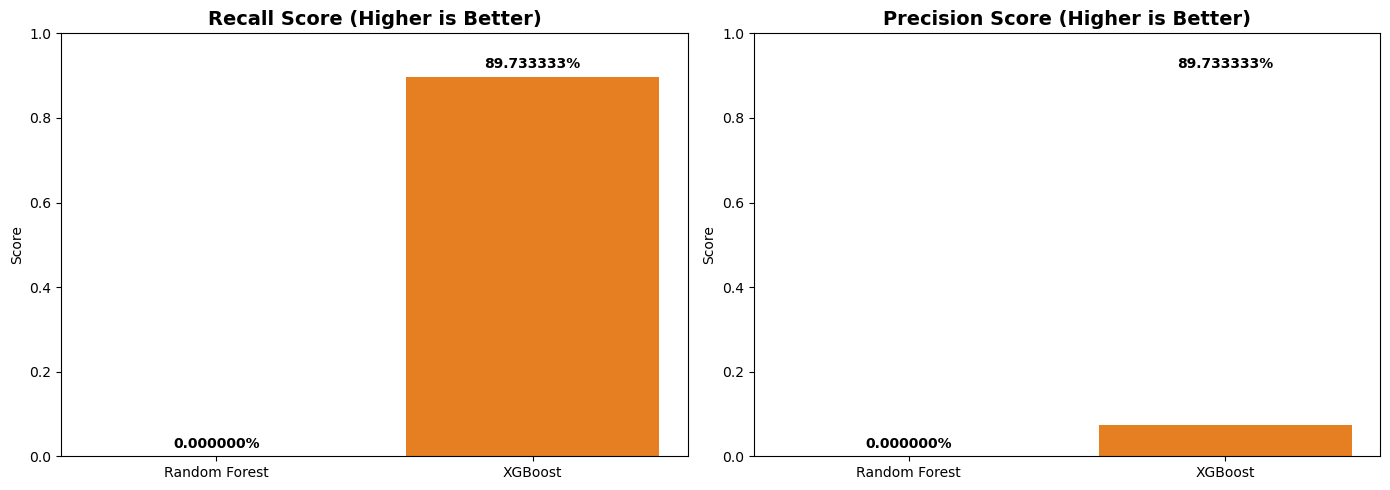

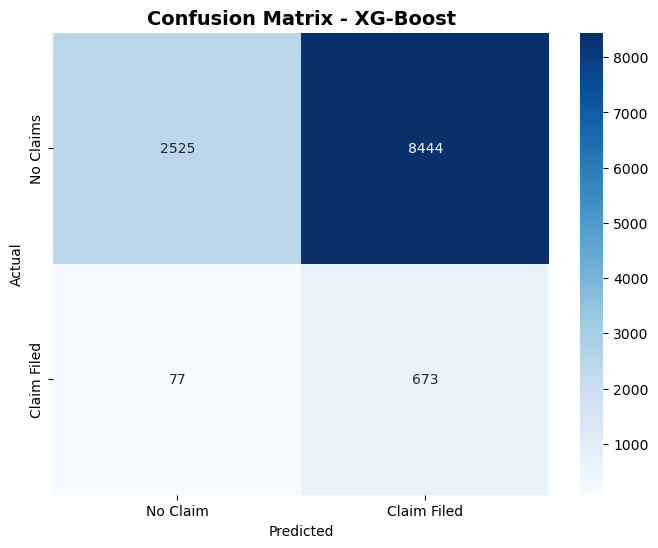


 confusion matrix Breakdown:
True negatives (Correctly predicted no claim ): 2525
False Positives (False Alarms): 8444
False Negatives (Missed claims -bad!): 77
True Positives (Correctly caught claims): 673


In [13]:
#comparing models
models =['Random Forest','XGBoost']
recalls = [recall_rf, recall_xgb]
precisions = [precision_rf, precision_xgb]

fig , axes = plt.subplots(1,2, figsize=(14,5))

# recall comparison
axes[0].bar(models, recalls, color =['#3498db','#e67e22'])
axes[0].set_title('Recall Score (Higher is Better)',fontsize =14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_ylim([0,1])
for i,v in enumerate(recalls):
    axes[0].text(i, v+0.02, f'{v:2%}', ha ='center', fontweight='bold')
    
axes[1].bar(models , precisions, color=['#3498db','#e67e22'])
axes[1].set_title('Precision Score (Higher is Better)',fontsize =14, fontweight='bold')
axes[1].set_ylabel('Score')
axes[1].set_ylim([0,1])
for i,v in enumerate(recalls):
    axes[1].text(i, v+0.02, f'{v:2%}', ha ='center', fontweight='bold')
    
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot =True , fmt='d', cmap ='Blues', xticklabels =['No Claim','Claim Filed'],yticklabels=['No Claims','Claim Filed'])
plt.title('Confusion Matrix - XG-Boost', fontsize =14, fontweight ='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n confusion matrix Breakdown:")
print(f"True negatives (Correctly predicted no claim ): {cm[0][0]}")
print(f"False Positives (False Alarms): {cm[0][1]}")
print(f"False Negatives (Missed claims -bad!): {cm[1][0]}")
print(f"True Positives (Correctly caught claims): {cm[1][1]}")

In [14]:
#“My XGBoost model achieved around 90% recall on insurance claim prediction. Although precision was low due to class imbalance, this was acceptable because the business cost of missing a claim is far higher than investigating false positives. The model successfully minimized false negatives, which was the primary business objective.

Top 10 most important features:
                          feature  importance
1                     vehicle_age    0.178085
18                   displacement    0.061597
13         is_adjustable_steering    0.046630
25                   gross_weight    0.045643
0             subscription_length    0.045144
15             is_parking_sensors    0.039543
6                           model    0.038289
23                         length    0.037369
19                       cylinder    0.032981
35  is_day_night_rear_view_mirror    0.032638


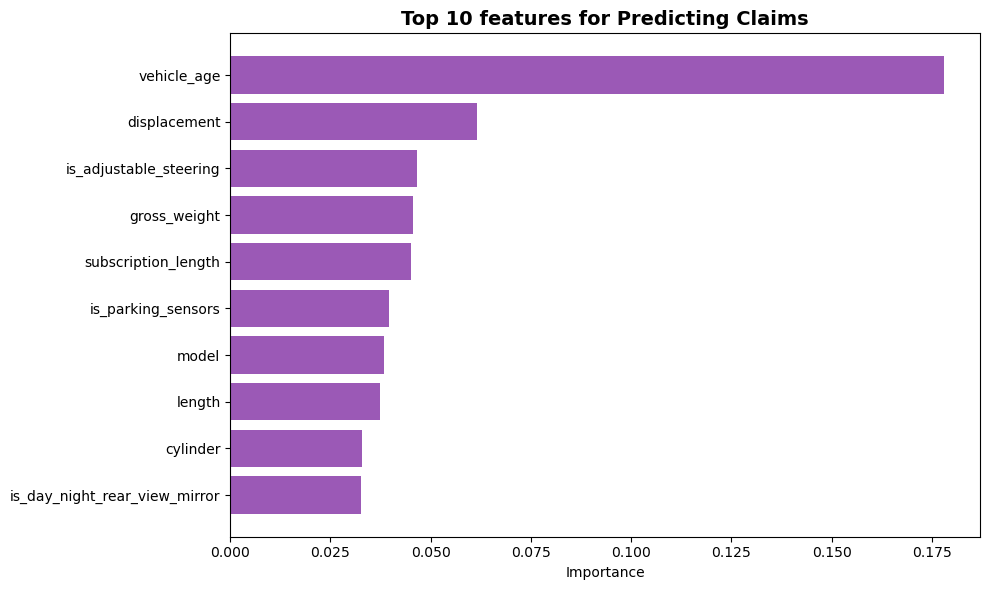

In [15]:
#fearture importance 
feature_importance  = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

print("Top 10 most important features:")
print(feature_importance)

#visaulize
plt.figure(figsize=(10,6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#9b59b6')
plt.xlabel('Importance')
plt.title('Top 10 features for Predicting Claims', fontsize=14, fontweight ='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
#lets calculate cost value of our model
#business impact calculation
avg_claim_cost =10000 
investigation_cost = 100

#get confusin matrix values
tn,fp,fn,tp =cm.ravel()

money_saved_from_catching_claims = tp* avg_claim_cost
money_lost_from_missed_claims = fn * avg_claim_cost
money_spent_on_false_alarms = fp * investigation_cost

net_benefit = money_saved_from_catching_claims - money_spent_on_false_alarms
potential_loss_without_model = (tp+fn)* avg_claim_cost

print("Business Impact analysis")
print("="*50)
print(f"✅ Money saved (caught claims): ${money_saved_from_catching_claims:,}")
print(f"❌ Money lost (missed claims): ${money_lost_from_missed_claims:,}")
print(f"💸 Money spent (false alarms): ${money_spent_on_false_alarms:,}")
print(f"\n🎯 Net Benefit: ${net_benefit:,}")
print(f"📊 Potential Loss Without Model: ${potential_loss_without_model:,}")
print(f"🏆 Value Created: {(net_benefit/potential_loss_without_model)*100:.1f}% of potential loss prevented!")

Business Impact analysis
✅ Money saved (caught claims): $6,730,000
❌ Money lost (missed claims): $770,000
💸 Money spent (false alarms): $844,400

🎯 Net Benefit: $5,885,600
📊 Potential Loss Without Model: $7,500,000
🏆 Value Created: 78.5% of potential loss prevented!


In [17]:
def predict_claim_risk(customer_data, model, threshold=0.4):
    """
    Predict if a customer will file a claim using a custom threshold
    """
    customer_df = pd.DataFrame([customer_data])
    
    # Encode categorical features
    for col in categorical_features:
        if col in customer_df.columns:
            try:
                customer_df[col] = label_encoders[col].transform(
                    customer_df[col].astype(str)
                )
            except:
                customer_df[col] = 0  # unseen category
    
    # Ensure all training columns exist
    for col in X.columns:
        if col not in customer_df.columns:
            customer_df[col] = 0
    
    # Reorder columns
    customer_df = customer_df[X.columns]
    
    # Predict probability
    claim_prob = model.predict_proba(customer_df)[0][1]
    
    # Apply threshold
    prediction = 1 if claim_prob >= threshold else 0
    
    return prediction, claim_prob


In [18]:
sample_customer = {
    'age': 35,
    'vehicle_age': 5,
    'fuel_type': 'Petrol',
    'max_power': 110,
    'airbags': 4,
    'is_esc': 1,
    # add remaining features if required
}

prediction, prob = predict_claim_risk(
    sample_customer,
    xgb_model,
    threshold=0.4
)

print("🔮 PREDICTION RESULT")
print("="*40)
print(f"Claim Probability: {prob:.2%}")
print(f"Prediction: {'WILL FILE CLAIM' if prediction == 1 else 'NO CLAIM EXPECTED'}")


🔮 PREDICTION RESULT
Claim Probability: 20.23%
Prediction: NO CLAIM EXPECTED


In [19]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# ---------------- LOAD MODEL ----------------
model = joblib.load("xgb_claim_model.pkl")
label_encoders = joblib.load("label_encoders.pkl")
feature_columns = joblib.load("feature_columns.pkl")

st.set_page_config(page_title="Insurance Claim Risk Predictor", layout="centered")

st.title("🛡 Insurance Claim Risk Predictor")
st.write("Answer simple questions. If you're unsure, just choose an approximate option.")

# ---------------- USER INPUTS ----------------
st.header("📋 Customer Details")

age = st.slider("Customer Age", 18, 80, 35,
                 help="Approximate age is fine")

vehicle_age = st.slider("Vehicle Age (years)", 0, 20, 5,
                         help="How old is the vehicle?")

fuel_type = st.selectbox(
    "Fuel Type",
    ["Petrol", "Diesel", "CNG", "Electric", "Not sure"],
    help="Select 'Not sure' if unknown"
)

max_power = st.slider(
    "Engine Power (approx)",
    50, 300, 100,
    help="You can estimate — exact value not required"
)

airbags = st.selectbox(
    "Number of Airbags",
    [0, 2, 4, 6, "Not sure"]
)

is_esc = st.radio(
    "Does the vehicle have ESC (Electronic Stability Control)?",
    ["Yes", "No", "Not sure"]
)

# ---------------- HANDLE UNKNOWN VALUES ----------------
if fuel_type == "Not sure":
    fuel_type = "Petrol"

if airbags == "Not sure":
    airbags = 2

if is_esc == "Yes":
    is_esc = 1
elif is_esc == "No":
    is_esc = 0
else:
    is_esc = 0

# ---------------- CREATE INPUT DATAFRAME ----------------
input_data = {
    "age": age,
    "vehicle_age": vehicle_age,
    "fuel_type": fuel_type,
    "max_power": max_power,
    "airbags": airbags,
    "is_esc": is_esc
}

df = pd.DataFrame([input_data])

# ---------------- ENCODE CATEGORICAL ----------------
for col, encoder in label_encoders.items():
    if col in df.columns:
        try:
            df[col] = encoder.transform(df[col].astype(str))
        except:
            df[col] = 0

# ---------------- ALIGN FEATURES ----------------
for col in feature_columns:
    if col not in df.columns:
        df[col] = 0

df = df[feature_columns]

# ---------------- PREDICTION ----------------
if st.button("🔮 Predict Claim Risk"):
    probability = model.predict_proba(df)[0][1]
    prediction = "HIGH RISK" if probability >= 0.4 else "LOW RISK"

    st.subheader("📊 Prediction Result")

    if prediction == "HIGH RISK":
        st.error(f"⚠ High chance of claim\n\nProbability: {probability:.2%}")
    else:
        st.success(f"✅ Low chance of claim\n\nProbability: {probability:.2%}")

    st.write("### ℹ What this means")
    st.write(
        "This prediction is based on patterns learned from historical insurance data. "
        "It is meant to **assist decision-making**, not replace human judgment."
    )


Writing app.py


In [ ]:
!streamlit run app.py
